# First Baseline Model - Random Forest

#### ``Objectives``
1. Implement a Baseline Models for run value prediction PRE BATTED-BALL
2. Turn to a Random Forest for the another baseline model

### Import Libraries

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# decision tree
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor


# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# misc
import imblearn
import os
import glob


#### Clear output and stored data:



In [3]:
os.system('clear') 

0

---
#### <span style="color:chocolate">  Step 1: Data ingestion </span>

I already created the training data in another file:
 <span style="color:gray">TrackMan data of 2024 spring season</span> function below according to the following guidelines:

 a) Read all the csv files in the directory and merge them into a single dataframe \
 b) Save the dataframe to a csv file

In [4]:
# dont need to run this again since already created the training data

def load_data(path: str, num_columns=60) -> pd.DataFrame:
    """
    Loads and merges CSV files from the specified directory, excluding files with 'player positioning' in their names.
    
    Parameters:
    path (str): The directory path containing the CSV files.

    Returns:
    pandas.DataFrame: The merged DataFrame containing data from the selected CSV files.
    """
    try:
        # Ensure the directory exists
        if not os.path.exists(path):
            raise FileNotFoundError(f"The directory '{path}' does not exist.")

        # Get all files in the directory that end with .csv, excluding those with 'player positioning' in the name
        all_files = [
            file for file in glob.glob(f"{path}/*.csv") if 'player positioning' not in file
        ]

        # Raise an exception if no valid files are found
        if not all_files:
            raise ValueError(f"No valid CSV files found in the directory '{path}'.")

        # Set the indices of the columns to keep
        columns_to_keep = list(range(num_columns))  # will set that in the function call but usually 60 will be fine

        # Read and merge the filtered files with the specified columns
        df_list = [pd.read_csv(filename, usecols=columns_to_keep) for filename in all_files]
        merged_df = pd.concat(df_list, ignore_index=True)

        # Save the merged DataFrame to a CSV
        output_path = "/Users/tommayer/Desktop/games_test.csv"
        merged_df.to_csv(output_path, index=False)

        return merged_df

    except FileNotFoundError as fnf_error:
        print(f"Error: {fnf_error}")
    except ValueError as val_error:
        print(f"Error: {val_error}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


#### NOTE: 
I don't know if it's smart to load the data and concatenate all rows every time.  I could make it more like appending rows to the dataframe.

In [5]:
# ONLY COLUMNS with data from pre-batted ball + RunsScored as our target variable
required_columns = ['TaggedPitchType', 'AutoPitchType', 'RelSpeed', 'RelHeight', 'VertRelAngle', 'HorzRelAngle', 'PitchCall',
                      'SpinRate', 'SpinAxis', 'Tilt', 'Extension','InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle']

# RunsScored column is gone

In [6]:
path = "/Users/tommayer/Desktop/training_data.csv"
#data = load_data(path)
data = pd.read_csv(path, usecols=required_columns)
## drastically reduces the number of rows and columns -> way less memory

Make new column for Whiffs


In [7]:
# Create boolean column for Whiffs (True if PitchCall is 'StrikeSwinging', False otherwise)
data['Whiff'] = data['PitchCall'] == 'StrikeSwinging'

In [8]:
data.drop(columns=['PitchCall'], inplace=True)

In [9]:
# peer at data and get a sense of the shape
data.head(5)
#print(f'Data shape: {data.shape}')

,TaggedPitchType,AutoPitchType,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,Extension,InducedVertBreak,HorzBreak,VertApprAngle,HorzApprAngle,Whiff
0,Slider,Slider,86.34831,-5.087035,-0.556059,2514.190308,69.694698,8:15,6.89596,5.20061,-1.26150,-6.71201,-12.231122,-1.751516,False
1,Fastball,Four-Seam,94.49974,-3.133086,-0.492520,2095.787589,190.374426,12:15,6.87165,5.83655,20.20828,3.49654,-5.365324,0.134391,False
2,Fastball,Four-Seam,94.81021,-3.910073,-1.135525,1996.806823,178.803234,12:00,6.94572,5.67326,22.06875,-0.43740,-5.815582,-1.213668,False
3,Slider,Slider,86.30865,-1.385858,-0.791508,3480.483920,100.930240,9:15,6.96039,5.43599,2.34610,-6.38485,-7.862841,-1.929632,False
4,Slider,Slider,87.45870,-4.605749,-1.323250,1287.761851,79.042003,8:45,6.99938,5.28786,0.27646,-4.37162,-11.264591,-2.102031,False


---
#### <span style="color:chocolate"> Step 2: Exploratory data analysis (EDA) </span>
- check for missing values
- check for duplicates
- check for outliers
- check for class imbalance


Rows to be dropped if N/A: 
- our target variables
- name, date, location, team??


In [10]:
new_required_columns = ['TaggedPitchType', 'AutoPitchType', 'RelSpeed', 'RelHeight', 'VertRelAngle', 'HorzRelAngle',
                      'SpinRate', 'SpinAxis', 'Tilt', 'Extension','InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle']


In [11]:
# drop rows without certain columns
data = data.dropna(subset=new_required_columns)

In [12]:
# check how many rows were dropped
print(f'Number of rows dropped: {data.shape[0] - len(data)}')


Number of rows dropped: 0


Check data types:

In [99]:
print(data.dtypes)

TaggedPitchType      object
AutoPitchType        object
RelSpeed            float64
VertRelAngle        float64
HorzRelAngle        float64
SpinRate            float64
SpinAxis            float64
Tilt                 object
RelHeight           float64
Extension           float64
InducedVertBreak    float64
HorzBreak           float64
VertApprAngle       float64
HorzApprAngle       float64
Whiff                  bool
dtype: object


In [13]:
independent_vars = data.drop(['Whiff'], axis=1)
dependent_var = data['Whiff']

In [14]:
ind_names = independent_vars.columns
# reference this down below so i dont have to list them out there
# Get column names by data type
categorical_columns = independent_vars.select_dtypes(include=['object']).columns.tolist()
numerical_columns = independent_vars.select_dtypes(include=['float64', 'int64']).columns.tolist()



In [15]:
print(f'Categorical columns: {categorical_columns}')
print(f'Numerical columns: {numerical_columns}')

Categorical columns: ['TaggedPitchType', 'AutoPitchType', 'Tilt']
Numerical columns: ['RelSpeed', 'VertRelAngle', 'HorzRelAngle', 'SpinRate', 'SpinAxis', 'RelHeight', 'Extension', 'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle']


### Feature Engineering:

---
#### <span style="color:chocolate"> Step 3: Data Preprocessing </span>
- drop columns that are not useful?
- encode labels 
- split into training and testing data
- standardize data

Working with certain data types: \
a) numerical data (float, int)  \
    - scale data \
    - RelSpeed, SpinRate, InducedVertBreak, HorzBreak, ExitSpeed, etc \
    \
b) categorical data (object/string) \
    - encode data (one-hot encoding with sklearn LabelEncoder) \
    - TaggedPitchType, AutoPitchType, PitchCall, KorBB, TaggedHitType, PlayResult


In [16]:
def preprocess_data(data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]:
    """
    Preprocesses the data by identifying column types, encoding categorical data, and scaling numerical data.
    Returns train/test/validation splits of features and target.

    A series is a 1D array-like or list-like object that contains a single column of data (test and validation sets).
    """
    
    # 1. Identify column types
    numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = data.select_dtypes(include=['object']).columns

    # 2. Handle categorical data
    # For simple categorical variables, use Label Encoding
    """ for col in ['TaggedPitchType', 'AutoPitchType']:
        le = LabelEncoder()
        data[f'{col}_encoded'] = le.fit_transform(data[col])
        ## Note: label encoding assumes an order to the categories """

    # For nominal variables with many categories, use One-Hot Encoding
    data = pd.get_dummies(data, columns=categorical_columns)

    # 3. Scale numerical features
    scaler = StandardScaler()
    numerical_features = numerical_columns
    data[numerical_features] = scaler.fit_transform(data[numerical_features])

    # 4. Split into features and target
    X = data.drop(['Whiff'], axis=1)
    y = data['Whiff']

    # 6. Split into train/test/validation sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
    

    print(f'X_train shape: {X_train.shape}')
    print(f'X_val shape: {X_val.shape}')
    print(f'X_test shape: {X_test.shape}')
    print(f'y_train shape: {y_train.shape}')
    print(f'y_val shape: {y_val.shape}')
    print(f'y_test shape: {y_test.shape}')

    return X_train, X_test, X_val, y_train, y_test, y_val

In [19]:
X_train, X_test, X_val, y_train, y_test, y_val = preprocess_data(data)

X_train shape: (673708, 81)
X_val shape: (168428, 81)
X_test shape: (210534, 81)
y_train shape: (673708,)
y_val shape: (168428,)
y_test shape: (210534,)


---
#### <span style="color:chocolate"> Step 4: Modeling </span>
- train a decision tree
- train a random forest
- train a gradient boosting machine (XGBoost)
- compare the three models

#### Feedforward Neural Network
- First, let's try a feedforward neural network (FNN)
- simple architecture with multiple dense layers
- experiment with different activation functions and optimizers
- Adam is the most popular optimizer for deep learning
- will start with Adam, go to SGD for CNN

* CNN is good for finding patterns in structured data*
* FNN is good for finding patterns in sequential data*


For whiff prediction, you might want to target:
- Loss: < 0.5
- AUC-ROC: > 0.7
- Precision: > 0.6
- Recall: > 0.6


If validation loss is bouncing while training loss decreases, it's a clear sign that the model is memorizing the training data rather than learning generalizable patterns. The key is to find the right balance of model capacity and regularization.

#### Recurrent Neural Network
- good for sequential data like run value
- probably not necessary for this problem since pitches are independent events


In [32]:
# Convert pandas Series/DataFrames to numpy arrays
# Convert pandas Series/DataFrames to numpy arrays with explicit float32 dtype
X_train_np = X_train.to_numpy().astype('float32')
X_val_np = X_val.to_numpy().astype('float32')
y_train_np = y_train.to_numpy().astype('float32')
y_val_np = y_val.to_numpy().astype('float32')


In [33]:
# Compute class weights with numpy arrays
class_weights = compute_class_weight('balanced', 
                                   classes=np.array([False, True]),
                                   y=y_train_np)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_73 (Dense)                │ (None, 32)             │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,361 (13.13 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/20
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 2s 788us/step - AUC: 0.5161 - accuracy: 0.5218 - loss: 0.7703 - val_AUC: 0.6243 - val_accuracy: 0.6573 - val_loss: 0.6452
Epoch 2/20
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step - AUC: 0.5751 - accuracy: 0.5599 - loss: 0.7003 - val_AUC: 0.6545 - val_accuracy: 0.6428 - val_loss: 0.6467
Epoch 3/20
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - AUC: 0.6086 - accuracy: 0.5835 - loss: 0.6773 - val_AUC: 0.6688 - val_accuracy: 0.6348 - val_loss: 0.6470
Epoch 4/20
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - AUC: 0.6277 - accuracy: 0.5965 - loss: 0.6675 - val_AUC: 0.6797 - val_accuracy: 0.6322 - val_loss: 0.6430
Epoch 5/20
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - AUC: 0.6455 - accuracy: 0.6036 - loss: 0.6595 - val_AUC: 0.6878 - val_accuracy: 0.6269 - val_loss: 0.6416
Epoch 6/20
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - AUC: 0.6560 - accuracy: 0.6066 - loss: 0.6559 - val_AUC: 0.6924 - val_accuracy: 0.6346 - val_loss: 0.6341
Epoch 7/20
1316/

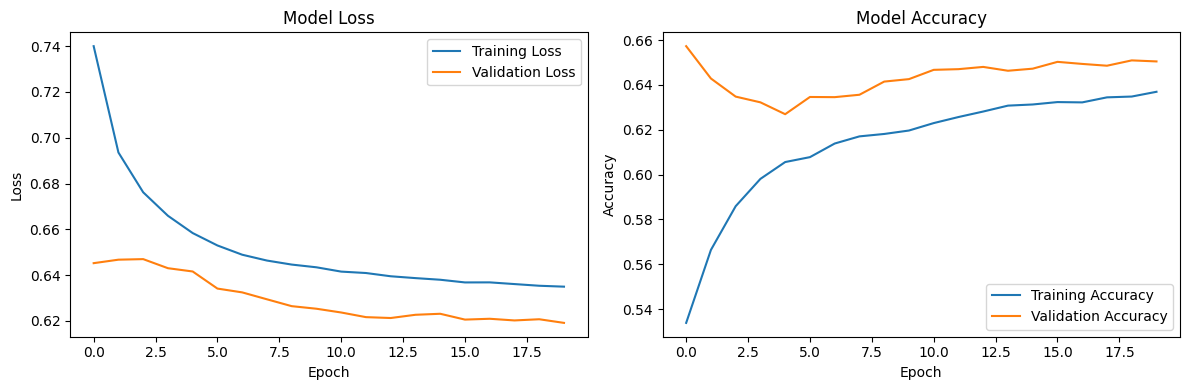

In [51]:
# Define the model
model = Sequential([
    # First layer
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),  # Increased from 16
    BatchNormalization(),
    Dropout(0.3),
    
    # Second layer
    Dense(16, activation='relu'),  # Increased from 8
    BatchNormalization(),
    Dropout(0.2),
    
    # Output layer
    Dense(1, activation='sigmoid')  # Changed from tanh to sigmoid
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC']  # Added AUC metric
)
# Add callbacks for better training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]

# Print model summary
model.summary()

# Train the model with class weights
history = model.fit(
    X_train_np, y_train_np,
    epochs=20,
    batch_size=512,
    validation_data=(X_val_np, y_val_np),
    class_weight=class_weight_dict,
    verbose=1,
    callbacks=callbacks
)

# Plot training history
plt.figure(figsize=(12, 4))

# plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Hidden layers | Hidden sizes | Activation| Optimizer | Learning rate | #Parameters | Training accuracy| Validation accuracy
-|-|-|-|-|-|-|-
 3 | [128,64,32] | relu | Adam |0.01| 20,865 | .49 | .10
 3 | [64,32,16] | relu | Adam |0.01| 7873 | .79 | .89
 3 | [64,32] | relu | Adam |0.01| 7873 | .54 | .62
 digits | [128] | relu | Adam |0.01| 101770 | |
 digits | [256, 128] | relu | Adam |0.01| 235146 | |
-|-|-|-|-|-|-|-
 fashion | [] | tanh | SGD |0.01| 7850 | |
 fashion | [] | relu | SGD |0.01| 7850 | |
 fashion | [] | relu | Adam |0.01| 7850 | |
 fashion | [128] | relu | Adam |0.01| 101770 | |
 fashion | [256, 128] | relu | Adam |0.01| 235146 | |